In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()

In [3]:
wind_table[:2], len(wind_table)

(            MJD           TIMESTAMP  WIND_SPEED  WIND_DIRECTION       GUST
 0  58569.131042 2019-03-27 03:08:42   17.200001      168.000000  99.300003
 1  58569.132477 2019-03-27 03:10:46   14.300000      175.699997  99.300003,
 1036477)

In [4]:
shake_table[:2], len(shake_table)

(            MJD           TIMESTAMP  WIND_GUST  WIND_SHAKE
 0  59307.129074 2021-04-03 03:05:52          1           0
 1  59307.129213 2021-04-03 03:06:04          1           1,
 102178)

In [5]:
exposure_table[:2], len(exposure_table)

(   EXPID           MJD                  TIMESTAMP SURVEY PROGRAM   MOUNT_EL  \
 0  90224  59364.148239 2021-05-30 03:33:27.849600    sv3  BACKUP  81.250550   
 1  90225  59364.154715 2021-05-30 03:42:47.376000    sv3  BRIGHT  56.109587   
 
      MOUNT_AZ  
 0  143.299106  
 1  201.243202  ,
 21030)

In [6]:
set(exposure_table['PROGRAM'])

{'BACKUP', 'BRIGHT', 'DARK'}

In [16]:
def calculate_angle_difference(angle1, angle2):
    """
    Calculate the absolute angular difference between two angles in degrees,
    considering the circular nature of angles (0-360 degrees).
    
    Parameters:
    -----------
    angle1, angle2 : float
        Angles in degrees
        
    Returns:
    --------
    float
        Absolute angular difference in degrees (0-180)
    """
    diff = abs(angle1 - angle2) % 360
    return min(diff, 360 - diff)

def add_wind_statistics(exposure_table, shake_table, wind_table):
    """
    Add columns to exposure_table containing wind statistics from both shake_table 
    and wind_table within each exposure's time window, including the opening angle
    between wind direction and telescope pointing.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information with columns:
        MJD, TIMESTAMP, PROGRAM, MOUNT_AZ
    shake_table : pandas.DataFrame
        Table containing wind shake information with columns:
        MJD, TIMESTAMP, WIND_GUST, WIND_SHAKE
    wind_table : pandas.DataFrame
        Table containing wind measurements with columns:
        MJD, TIMESTAMP, WIND_SPEED, WIND_DIRECTION, GUST
        
    Returns:
    --------
    pandas.DataFrame
        exposure_table with additional wind statistics columns
    """
    # Create a copy of the exposure table to avoid modifying the original
    result_table = exposure_table.copy()
    
    # Define window lengths in seconds for each program type
    window_lengths = {
        'BACKUP': 300,
        'BRIGHT': 600,
        'DARK': 1200
    }
    
    # Initialize new columns with zeros
    new_columns = [
        'WIND_GUST_SUM', 'WIND_SHAKE_SUM',  # From shake_table
        'WIND_SPEED_AVG', 'WIND_SPEED_STD',  # From wind_table
        'WIND_DIRECTION_AVG', 'WIND_DIRECTION_STD',
        'GUST_AVG', 'GUST_STD',
        'WIND_OPENING_ANGLE'  
    ]
    for col in new_columns:
        result_table[col] = 0.0
    
    # Convert timestamps to pandas datetime
    shake_times = pd.to_datetime(shake_table['TIMESTAMP'])
    wind_times = pd.to_datetime(wind_table['TIMESTAMP'])
    
    # Process each exposure
    for i in range(len(result_table)):
        if((i%1000)==0):
            print(i, len(result_table))
        # Get the current row
        row = result_table.iloc[i]
        
        # Get the end time of the exposure
        end_time = pd.to_datetime(row['TIMESTAMP'])
        
        # Calculate start time based on the program type
        window_length = window_lengths[row['PROGRAM']]
        start_time = end_time - pd.Timedelta(seconds=window_length)
        
        # Find all shake_table entries within this time window
        shake_mask = (shake_times >= start_time) & (shake_times <= end_time)
        shake_window = shake_table[shake_mask]
        
        # Calculate statistics from shake_table
        result_table.iloc[i, result_table.columns.get_loc('WIND_GUST_SUM')] = shake_window['WIND_GUST'].sum()
        result_table.iloc[i, result_table.columns.get_loc('WIND_SHAKE_SUM')] = shake_window['WIND_SHAKE'].sum()
        
        # Find all wind_table entries within this time window
        wind_mask = (wind_times >= start_time) & (wind_times <= end_time)
        wind_window = wind_table[wind_mask]
        
        # Calculate statistics from wind_table
        if len(wind_window) > 0:  # Only calculate if we have data points
            # Wind speed statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_AVG')] = wind_window['WIND_SPEED'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_STD')] = wind_window['WIND_SPEED'].std()
            
            # Wind direction statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_AVG')] = wind_window['WIND_DIRECTION'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_STD')] = wind_window['WIND_DIRECTION'].std()
            
            # Gust statistics
            result_table.iloc[i, result_table.columns.get_loc('GUST_AVG')] = wind_window['GUST'].mean()
            result_table.iloc[i, result_table.columns.get_loc('GUST_STD')] = wind_window['GUST'].std()
            
            # Calculate opening angle between wind direction and telescope pointing
            wind_direction_avg = wind_window['WIND_DIRECTION'].mean()
            telescope_az = row['MOUNT_AZ']
            opening_angle = calculate_angle_difference(wind_direction_avg, telescope_az)
            result_table.iloc[i, result_table.columns.get_loc('WIND_OPENING_ANGLE')] = opening_angle
    
    return result_table

In [17]:
new_exposure_table = add_wind_statistics(exposure_table, shake_table, wind_table)

0 21030
1000 21030
2000 21030
3000 21030
4000 21030
5000 21030
6000 21030
7000 21030
8000 21030
9000 21030
10000 21030
11000 21030
12000 21030
13000 21030
14000 21030
15000 21030
16000 21030
17000 21030
18000 21030
19000 21030
20000 21030
21000 21030


In [18]:
new_exposure_astropy = Table.from_pandas(new_exposure_table)
new_exposure_astropy.write('extended_exposure_data.ecsv', format='ascii.ecsv', overwrite=True)

In [19]:
new_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()

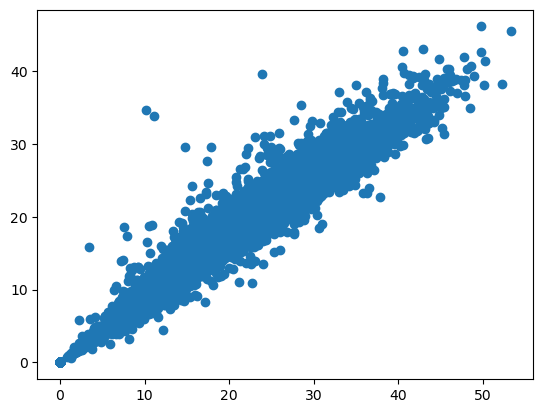

In [20]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['GUST_AVG'])

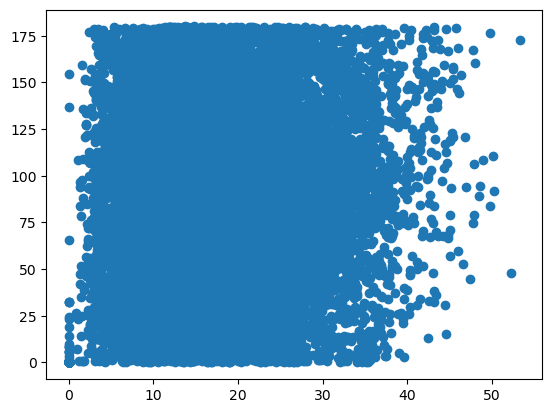

In [21]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['WIND_OPENING_ANGLE'])

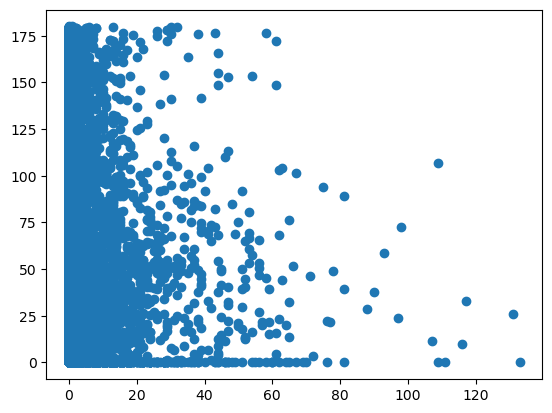

In [22]:
plt.scatter(new_exposure_table['WIND_SHAKE_SUM'],new_exposure_table['WIND_OPENING_ANGLE'])

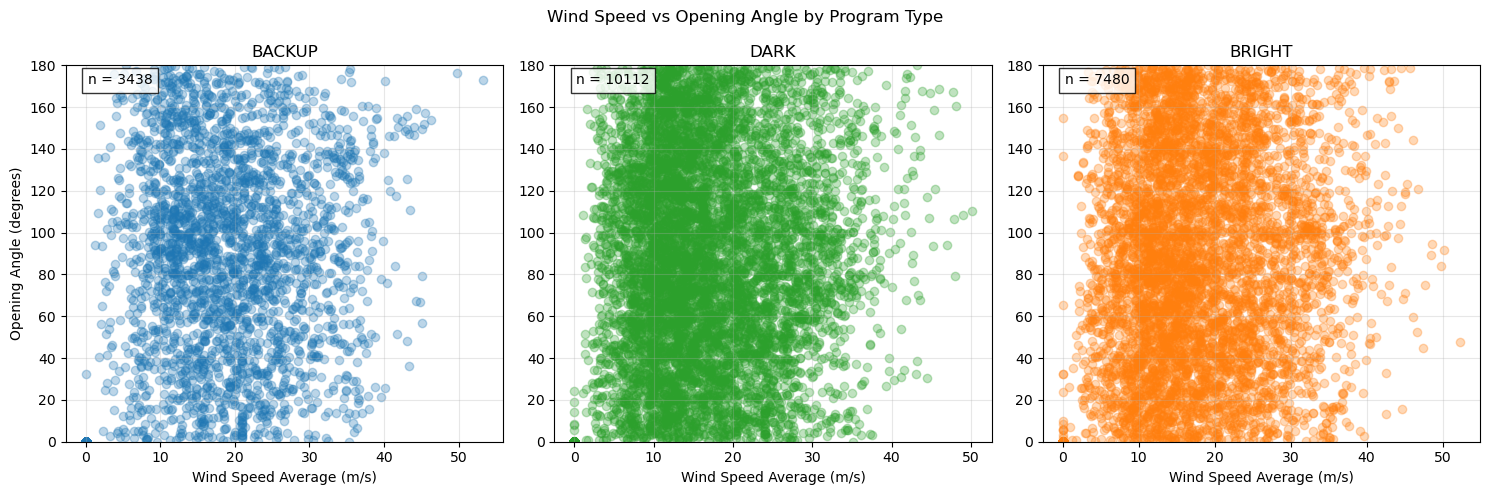

In [25]:
def plot_wind_speed_vs_angle(df):
    """
    Create a three-panel scatter plot of wind speed vs opening angle,
    separated by program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Create scatter plot for each program
    for ax, program, color in zip(axes, programs, colors):
        mask = df['PROGRAM'] == program
        program_data = df[mask]
        
        ax.scatter(program_data['WIND_SPEED_AVG'], 
                  program_data['WIND_OPENING_ANGLE'],
                  alpha=0.3, c=color, label=program)
        
        # Add labels and title
        ax.set_xlabel('Wind Speed Average (m/s)')
        ax.set_ylabel('Opening Angle (degrees)' if ax == axes[0] else '')
        ax.set_title(f'{program}')
        
        # Set y-axis limits
        ax.set_ylim(0, 180)
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Add count of points
        count = len(program_data)
        ax.text(0.05, 0.95, f'n = {count}', 
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle(new_exposure_table)
